In [ ]:
!unzip "./data.zip"

In [20]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.transforms import Resize
import torch
import seaborn as sns
from torchvision.io import read_image
from sklearn import metrics
# import time
from torch.optim.lr_scheduler import ReduceLROnPlateau

import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import albumentations as A
import torch.nn as nn
import matplotlib.pyplot as plt
from random import shuffle
import numpy as np
import cv2

TRAINING_DIR = "./Training"
TESTING_DIR = "./Testing"
GLIOMA_TUMOR = "glioma_tumor"
MENINGIOMA_TUMOR = "meningioma_tumor"
NO_TUMOR = "no_tumor"
PITUITARY_TUMOR = "pituitary_tumor"
VALIDATION_AMOUNT = 0.2
LABEL_LIST = {
    GLIOMA_TUMOR: 0,
    MENINGIOMA_TUMOR: 1,
    NO_TUMOR: 2,
    PITUITARY_TUMOR: 3
}

class ImagesMRIDataset(Dataset):
    def __init__(self, data, transformations = None):
        self.data = data
        self.transformations = transformations

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        if self.transformations == None:
            return cv2.imread(self.data[index][0]), self.data[index][1]
        return self.transformations(cv2.imread(self.data[index][0])), self.data[index][1]
        
def get_images_labels(img_dir):
    images_path = []
    labels = []
    for directory in LABEL_LIST.keys():
            current_path = img_dir + "/" + directory
            filenames = os.listdir(current_path)
            images_path += map(lambda x : current_path + "/" + x, filenames)
            labels += [LABEL_LIST[directory]] * len(filenames)
    result = list(zip(images_path, labels))
    shuffle(result)
    return result

def split_traing_data(final_info : list[tuple], validation : float):
    if (validation < 0.0 or validation > 1.0):
        print("Percent should be in range 0 - 1")
        exit(1)
    training_data = []
    validation_data = []
    for directory in LABEL_LIST.keys():
        current = list(filter(lambda x : x[1] == LABEL_LIST[directory], final_info))
        amount_training : int = int(len(current) * (1 - validation))
        training_data += current[:amount_training]
        validation_data += current[amount_training:]
    return training_data, validation_data

def split_for_cross_validation(final_info: list[tuple], number_splits : int):
    validation_split = 1 / number_splits
    chunk_values = []
    for i in range(number_splits):
        validation_split = 1 / (number_splits - i)
        final_info, chunk = split_traing_data(final_info, validation_split)
        chunk_values.append(chunk)
    return chunk_values

def get_data_distribution(data : list[tuple]):
    label_numbers = np.zeros(shape=(len(LABEL_LIST),))
    for label in LABEL_LIST.keys():
        idx = LABEL_LIST[label]
        label_numbers[idx] = len(list(filter(lambda x : x[1] == idx, data)))
    return label_numbers


def balance_no_tumor_class(path_image_label_info : list[tuple]):
    distribution = get_data_distribution(path_image_label_info)
    no_tumor_idx = LABEL_LIST[NO_TUMOR]
    no_tumor : list[tuple] = list(filter(lambda x : x[1] == no_tumor_idx, path_image_label_info))
    highest_number_class_index = np.argmax(distribution)
    how_many_more = distribution[highest_number_class_index] - 2 * len(no_tumor)
    result = path_image_label_info + no_tumor
    shuffle(no_tumor)
    result += no_tumor[0:int(how_many_more)]
    shuffle(result)
    return result

In [4]:
training_info =  get_images_labels(TRAINING_DIR)
test_info = get_images_labels(TESTING_DIR)
training_info, validation_info = split_traing_data(training_info,  VALIDATION_AMOUNT)
training_info_balanced = balance_no_tumor_class(training_info)
validation_info_balanced = balance_no_tumor_class(validation_info)

In [72]:

SIZE = (50, 50)
gamma_correction = A.RandomGamma(p=1.0)
normalize = A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5),
                         normalization='min_max', always_apply=None, p=1.0)
clahe : A.CLAHE = A.CLAHE()
blurring = A.AdvancedBlur()

def compute_transformations(image):
    image = cv2.resize(image, SIZE,  interpolation = cv2.INTER_LINEAR)
    gamma_crrected_image = gamma_correction.apply(image, 1.2)
    blurred_image = blurring.apply(gamma_crrected_image, kernel=np.ones(shape=(4, 4)) / 16)
    clahe_image = clahe.apply(blurred_image, clip_limit=5)
    sobelx = cv2.Sobel(clahe_image,cv2.CV_64F,1,0,ksize=3)
    sobely = cv2.Sobel(clahe_image,cv2.CV_64F,0,1,ksize=3)
    sobel_fiter_applied = cv2.magnitude(sobelx, sobely, clahe_image)
    _, sobel_fiter_applied = cv2.threshold(sobel_fiter_applied, 150, 255, cv2.THRESH_BINARY)
    compound_image = clahe_image + sobel_fiter_applied
    normalized_image = normalize.apply(compound_image)
    return np.array(normalized_image.transpose((2, 0, 1)), dtype=np.float32)
    
def test_transformation(image):
    image = cv2.resize(image, SIZE,  interpolation = cv2.INTER_LINEAR)
    normalized_image = normalize.apply(image)
    return np.array(normalized_image.transpose((2, 0, 1)), dtype=np.float32)


In [103]:
def training_loop(model, criterion, optimizer, dataloader, batch_size):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  current_training_loss = 0
  all_train_labels, all_train_preds = [], []
  model.train()
  for idx, (images, labels) in enumerate(dataloader):
    images, labels = images.to(device), labels.to(device)
    output = model(images)
    output = output.to(device)
    loss = criterion(output, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    current_training_loss += loss.item()
    all_train_preds.extend(output.argmax(dim=1).cpu().numpy())
    all_train_labels.extend(labels.cpu().numpy())
  current_train_accuracy = metrics.accuracy_score(all_train_labels, all_train_preds)
  return current_training_loss / dataloader.__len__() / batch_size, current_train_accuracy


def validation_loop(model, criterion, dataloader, batch_size):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    all_val_labels, all_val_preds = [], [],
    current_validation_loss = 0
    model.eval()
    with torch.no_grad():
      for idx, (images, labels) in enumerate(dataloader):
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        output = output.to(device)
        loss = criterion(output, labels)
        current_validation_loss += loss.item()
        all_val_labels.extend(labels.cpu().numpy())
        all_val_preds.extend(output.argmax(dim=1).cpu().numpy())
    return current_validation_loss / dataloader.__len__() / batch_size,  all_val_preds, all_val_labels

def train_model(model, epochs, training_dataloader, validation_dataloader, criterion, optimizer, lr_scheduler, batch_size):
  training_loss = np.zeros(shape=(epochs,))
  validation_loss = np.zeros(shape=(epochs,))
  training_accuracy = np.zeros(shape=(epochs,))
  validation_accuracy = np.zeros(shape=(epochs,))
  for i in range(epochs):
    Tloss, Taccuracy = training_loop(model, criterion, optimizer, training_dataloader, batch_size)
    Vloss, all_val_preds, all_val_labels = validation_loop(model, criterion, validation_dataloader, batch_size)
    lr_scheduler.step(Vloss)
    training_loss[i] = Tloss
    validation_loss[i] = Vloss
    training_accuracy[i] = Taccuracy
    validation_accuracy[i] = metrics.accuracy_score(all_val_labels, all_val_preds)
    if (np.argmax(validation_accuracy) == i):
      print(f"best model found at {i}")
      torch.save(model.state_dict(), "./best_model.pth")
    print(f"{i} is ready")
    if (i == epochs -1):
      print("termina aici")
      # torch.save(model.state_dict(), "./model.pth")
  return training_loss, validation_loss, training_accuracy, validation_accuracy

def test_model(model, dataloader, criterion, batch_size):
    loss, all_val_preds, all_val_labels = validation_loop(model, criterion, dataloader, batch_size)
    print("accuracy is:", metrics.accuracy_score(all_val_labels, all_val_preds))
    print("Loss is:", loss)
    confusion_matrix = metrics.confusion_matrix(all_val_preds, all_val_labels)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1, 2, 3])
    cm_display.plot()
    plt.show()
    


def plot_data(training_loss, validation_loss, training_accuracy, validation_accuracy):
  fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
  sns.lineplot(x=range(1, len(training_loss) + 1), y=training_loss, ax=ax1, label='Training Loss', marker='o')
  sns.lineplot(x=range(1, len(validation_loss) + 1), y=validation_loss, ax=ax1, label='Validation Loss', marker='o')
  ax1.set_xlabel("Epoch")
  ax1.set_ylabel("Loss")
  ax1.set_title("Training and Validation Loss Over Epochs")
  ax1.legend()

  sns.lineplot(x=range(1, len(training_accuracy) + 1), y=training_accuracy, ax=ax2, label='Training Accuracy', marker='o')
  sns.lineplot(x=range(1, len(validation_accuracy) + 1), y=validation_accuracy, ax=ax2, label='Validation Accuracy', marker='o')
  ax2.set_xlabel("Epoch")
  ax2.set_ylabel("Accuracy")
  ax2.set_title("Training and Validation Accuracy Over Epochs")
  ax2.legend()

  plt.tight_layout()
  plt.show()


In [112]:
EPOCHS = 20
BATCH_SIZE = 20
WIDTH = 4
FACTOR = 2
LR = 0.001
DECAY = 1e-3
PATIENCE = 3

def get_parameters(model):
  criterion = torch.nn.NLLLoss(reduction="sum")
  optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=DECAY)
  lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.8, threshold=1e-3, 
                                   patience=PATIENCE, verbose=1)
  return criterion, optimizer, lr_scheduler


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = nn.ReLU()
        self.width1 = WIDTH
        self.conv1 = nn.Conv2d(3, self.width1, kernel_size=(3, 3))
        self.bn1 = nn.BatchNorm2d(self.width1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)

        self.width2 = self.width1 * FACTOR
        self.conv2 = nn.Conv2d(self.width1, self.width2, kernel_size=(3, 3))
        self.bn2 = nn.BatchNorm2d(self.width2)
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)

        self.width3 = self.width2 * FACTOR
        self.conv3 = nn.Conv2d(self.width2, self.width3, kernel_size=(5, 5))
        self.bn3 = nn.BatchNorm2d(self.width3)
        self.maxpool3 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)

        self.width4 = self.width3 * FACTOR
        self.conv4 = nn.Conv2d(self.width3, self.width4, kernel_size=(3, 3))
        self.bn4 = nn.BatchNorm2d(self.width4)
        
        self.classification_layer = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(self.width4, self.width3),
            nn.Dropout(p=0.3),
            nn.Linear(self.width3, 4),
            nn.LogSoftmax(dim=1),
        )
        
    def forward(self, x : torch.tensor):
        x = self.maxpool1(self.relu(self.bn1(self.conv1(x))))
        x = self.maxpool2(self.relu(self.bn2(self.conv2(x))))
        x = self.maxpool3(self.relu(self.bn3(self.conv3(x))))
        x = self.relu(self.bn4(self.conv4(x)))
        return self.classification_layer(x)


training_dataloader = DataLoader(ImagesMRIDataset(training_info_balanced, transformations=compute_transformations), batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(ImagesMRIDataset(validation_info_balanced, transformations=test_transformation), batch_size=BATCH_SIZE, shuffle=True)
testing_dataloader = DataLoader(ImagesMRIDataset(test_info, transformations=test_transformation), batch_size=BATCH_SIZE, shuffle=True)


/home/alf/anul4/InvSup/tema2/venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


best model found at 0
0 is ready
best model found at 1
1 is ready
2 is ready
3 is ready
4 is ready
5 is ready
best model found at 6
6 is ready
best model found at 7
7 is ready
best model found at 8
8 is ready
9 is ready
10 is ready
11 is ready
12 is ready
best model found at 13
13 is ready
14 is ready
15 is ready
16 is ready
17 is ready
18 is ready
19 is ready
termina aici


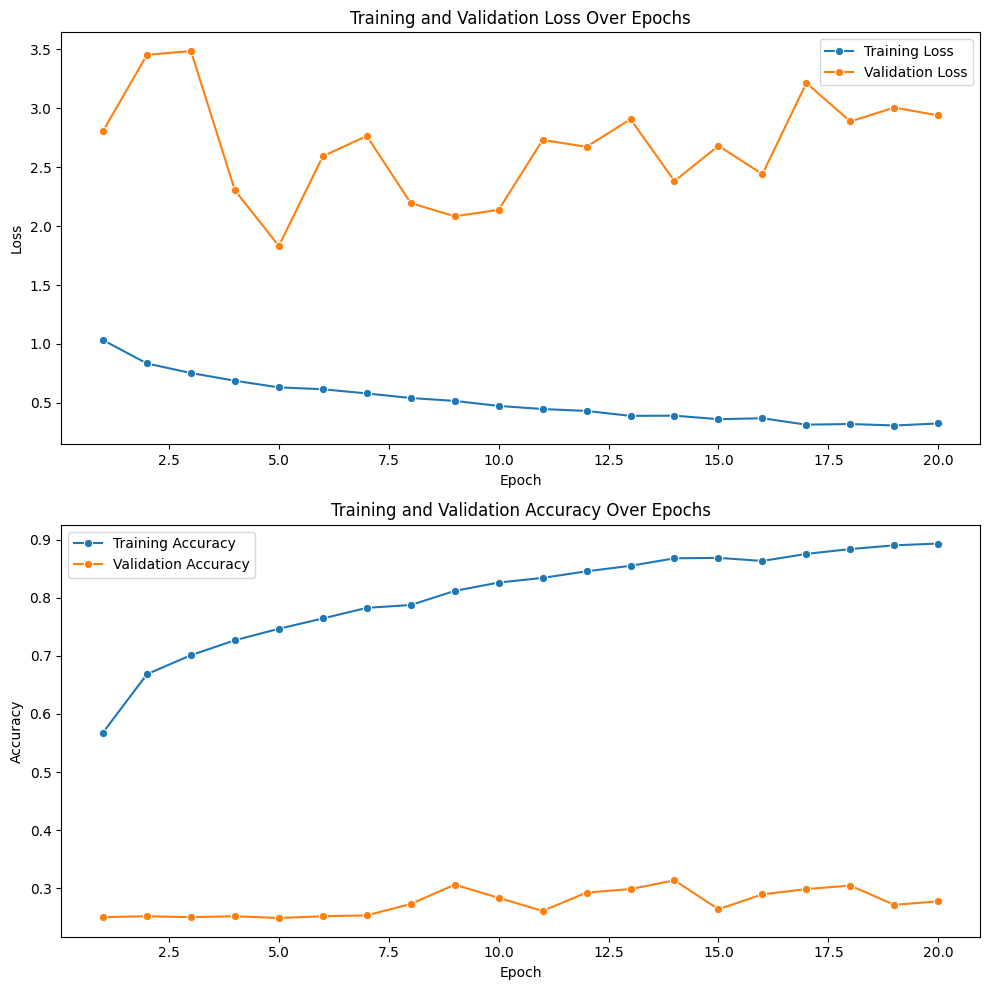

accuracy is: 0.3883248730964467
Loss is: 2.6201432472542874


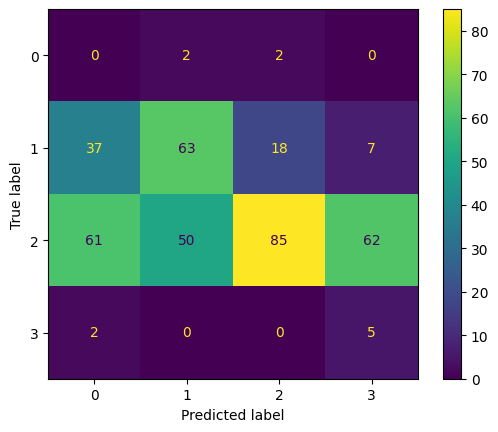

In [113]:

model = Net()
# if os.path.exists("./model.pth"):
#     model.load_state_dict(torch.load("./model.pth", weights_only=True))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion, optimizer, lr_scheduler = get_parameters(model)
training_loss, validation_loss, training_accuracy, validation_accuracy = train_model(model, EPOCHS,
    training_dataloader, validation_dataloader, criterion, optimizer, lr_scheduler, BATCH_SIZE)
plot_data(training_loss, validation_loss, training_accuracy, validation_accuracy)
test_model(model, testing_dataloader, criterion, BATCH_SIZE)

In [111]:
K = 5
training_info =  get_images_labels(TRAINING_DIR)
test_info = get_images_labels(TESTING_DIR)
data_chunks = split_for_cross_validation(training_info, K)
for chunk in data_chunks: 
    label_numbers = get_data_distribution(chunk)